In [1]:
%matplotlib inline
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import partial

In [2]:
def plot1(img1, title1=None, filename=None, figsize=(8, 4)):
    plt.figure(figsize=figsize)        
    if title1 is not None:
        plt.title(title1)
    plt.imshow(img1, cmap=plt.cm.Greys_r)
    
    if filename is not None:
        plt.savefig('./output_images/{}'.format(filename))
        
def plot2(img1, img2, title1=None, title2=None, filename=None, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    plt.subplot(121)
    if title1 is not None:
        plt.title(title1)
    plt.imshow(img1, cmap=plt.cm.Greys_r)
    
    plt.subplot(122)
    if title2 is not None:
        plt.title(title2) 
    plt.imshow(img2, cmap=plt.cm.Greys_r)
    
    if filename is not None:
        plt.savefig('./output_images/{}'.format(filename))

## Calibrate the camera

In [3]:
!ls ./camera_cal/

calibration10.jpg  calibration15.jpg  calibration1.jpg	 calibration5.jpg
calibration11.jpg  calibration16.jpg  calibration20.jpg  calibration6.jpg
calibration12.jpg  calibration17.jpg  calibration2.jpg	 calibration7.jpg
calibration13.jpg  calibration18.jpg  calibration3.jpg	 calibration8.jpg
calibration14.jpg  calibration19.jpg  calibration4.jpg	 calibration9.jpg


In [4]:
def read_imgs(file_pattern):
    return [cv2.imread(img) for img in glob.glob(file_pattern)]

(720, 1280, 3)

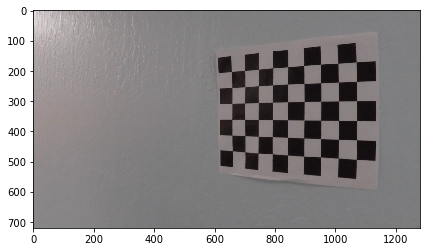

In [5]:
# Read images
calibration_imgs = read_imgs("./camera_cal/*.jpg")

# Show a calibration image
plot1(calibration_imgs[0])
calibration_imgs[0].shape

In [6]:
NX, NY = 9, 6

def find_chessboards(calibration_imgs, nx, ny):
    ret = []
    for i, img in enumerate(calibration_imgs):
        found, corners = cv2.findChessboardCorners(img, (nx, ny))
        cv2.drawChessboardCorners(img, (nx, ny), corners, found)
        if not found:
            print("WARN: Chessboard not found for image {}. Skipping.".format(i))
        else:
            ret.append(corners)
    return np.stack(ret)

In [7]:
imgpoints = find_chessboards(calibration_imgs, NX, NY)

WARN: Chessboard not found for image 5. Skipping.
WARN: Chessboard not found for image 15. Skipping.
WARN: Chessboard not found for image 16. Skipping.


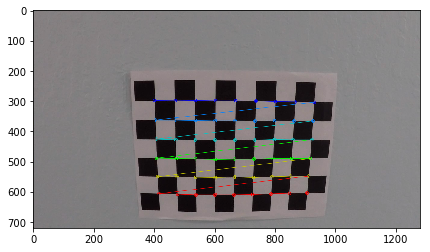

In [8]:
plot1(calibration_imgs[7], filename="chessboard.jpg")

In [9]:
def undistort(objpoints, imgpoints, shape=(720, 1280)):
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = \
        cv2.calibrateCamera(objpoints, imgpoints, tuple(reversed(shape)), None, None)
    def apply(x):
        return cv2.undistort(x, cameraMatrix, distCoeffs) 
    return apply

In [10]:
def create_objpoints(nx, ny):
    return np.array(
        [[[x, y, 0.] for y in range(6) for x in range(9)]] * len(imgpoints),
        dtype=np.float32)

In [11]:
objpoints = create_objpoints(NX, NY)

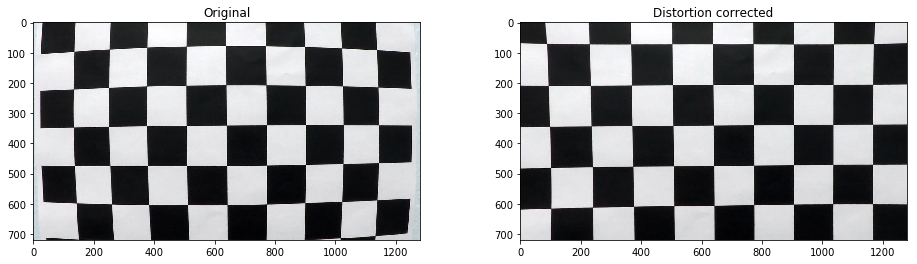

In [12]:
plot2(
    calibration_imgs[16], 
    undistort(objpoints, imgpoints)(calibration_imgs[16]), 
    title1="Original",
    title2="Distortion corrected",
    filename="distortion.jpg")

## Calculate perspective transformation

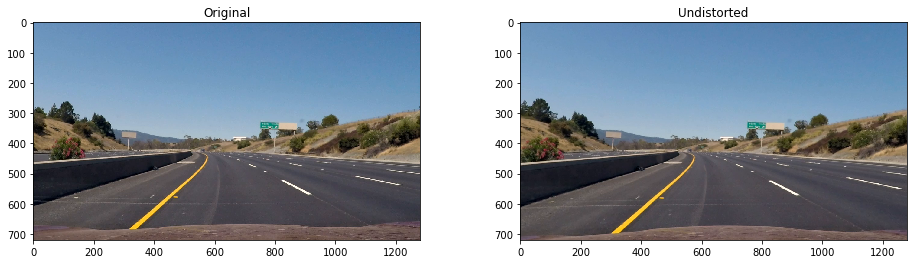

In [13]:
video = VideoFileClip("./project_video.mp4")
frame = next(video.iter_frames())
undistorted = undistort(objpoints, imgpoints, shape=frame.shape[:-1])(frame)
plot2(frame, undistorted, 'Original', 'Undistorted', filename='distortion-2.jpg')

In [14]:
def compose(*functions):
    def apply(x):
        for f in functions:
            x = f(x)
        return x
    return apply

In [15]:
def fork(*functions, join=partial(np.average, axis=0)):
    def apply(x):
        return join(np.array([f(x) for f in functions]))
    return apply

In [16]:
def scale(max=1.):
    def apply(input):
        return ((max * input) / input.max())
    return apply

In [17]:
def threshold(min, max, value=None):
    def apply(x):
        out = np.zeros_like(x, dtype=np.float32)        
        out[(x >= min) & (x <= max)] = value if value is not None else x[(x >= min) & (x <= max)]
        return out
    return apply

In [18]:
def convert_color(*args, **kwargs):
    def apply(input):
        return cv2.cvtColor(input, *args, **kwargs)
    return apply

In [19]:
def sobel(*args, **kwargs):
    def apply(input):
        return np.abs(cv2.Sobel(input, cv2.CV_32F, *args, **kwargs))
    return apply

In [20]:
def sobel_angle(*args, **kwargs):
    sobel_x = sobel(1, 0, *args, **kwargs)
    sobel_y = sobel(0, 1, *args, **kwargs)
    def apply(x):    
        return np.arctan2(np.abs(sobel_y(x)), np.abs(sobel_x(x)))
    return apply

In [21]:
def sobel_magnitude(*args, **kwargs):
    sobel_x = sobel(1, 0, *args, **kwargs)
    sobel_y = sobel(0, 1, *args, **kwargs)
    def apply(x):    
        return np.sqrt(sobel_y(x) ** 2 + sobel_x(x) ** 2)
    return apply

In [22]:
def sobel_angle(*args, **kwargs):
    sobel_x = sobel(1, 0, *args, **kwargs)
    sobel_y = sobel(0, 1, *args, **kwargs)
    def apply(x):    
        return np.arctan2(np.abs(sobel_y(x)), np.abs(sobel_x(x)))
    return apply

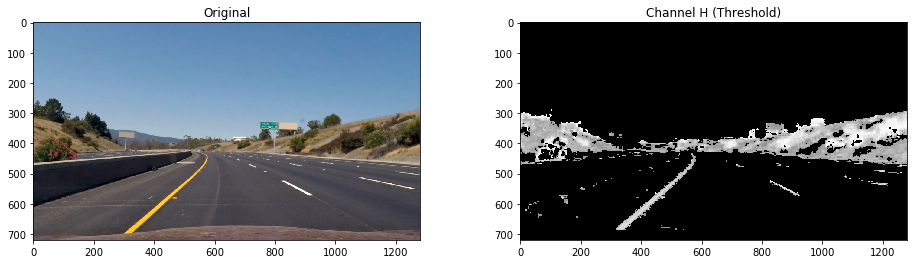

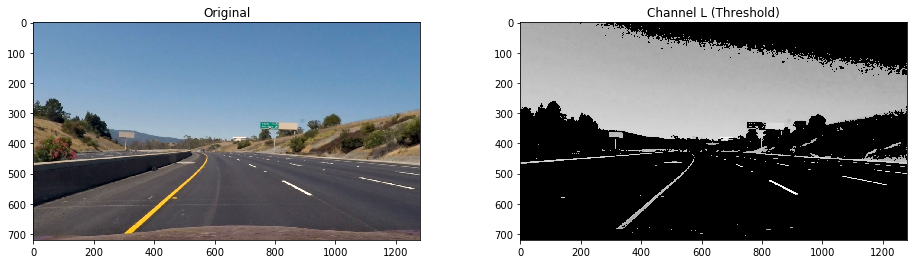

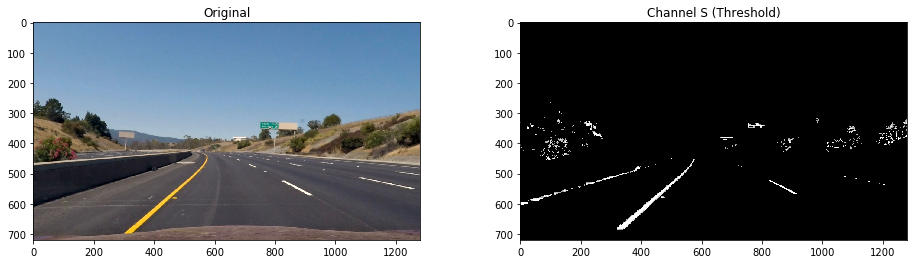

In [23]:
im = convert_color(cv2.COLOR_RGB2HLS)(frame)

channel_h = threshold(15, 30)(im[..., 0])
channel_l = threshold(140, 255)(im[..., 1])
channel_s = threshold(128, 255)(im[..., 2])

plot2(undistorted, channel_h, 'Original', 'Channel H (Threshold)')
plot2(undistorted, channel_l, 'Original', 'Channel L (Threshold)')
plot2(undistorted, channel_s, 'Original', 'Channel S (Threshold)')

In [24]:
def display_video(video):
    return HTML('<video width="960" height="540" controls src="{}"/>'.format(video))

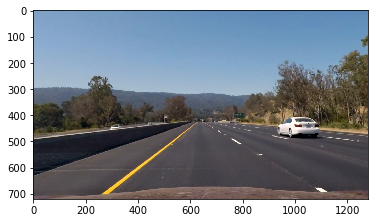

In [25]:
frame = video.get_frame(16)
undistorted = undistort(objpoints, imgpoints)(frame)
plt.imshow(undistorted)

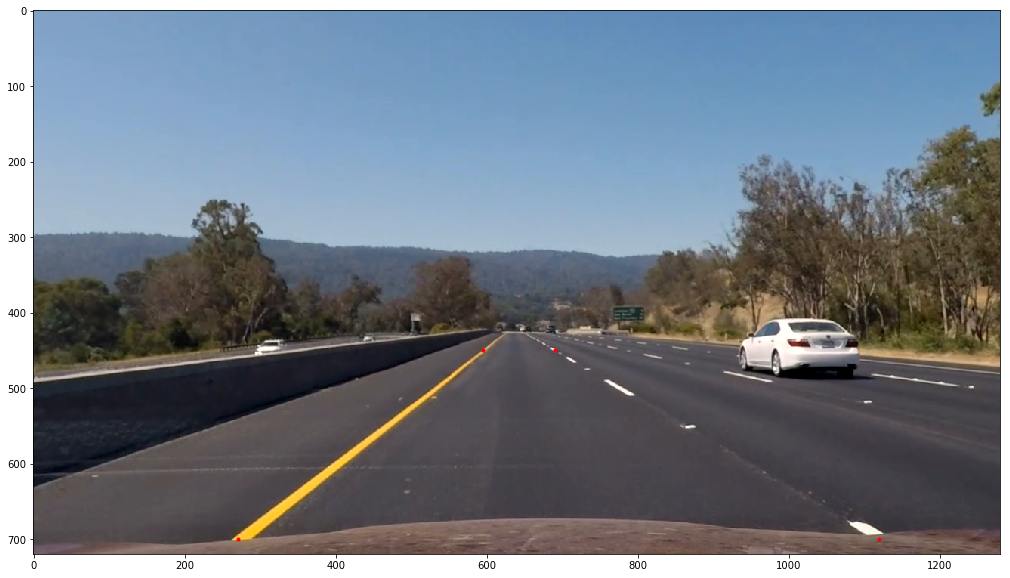

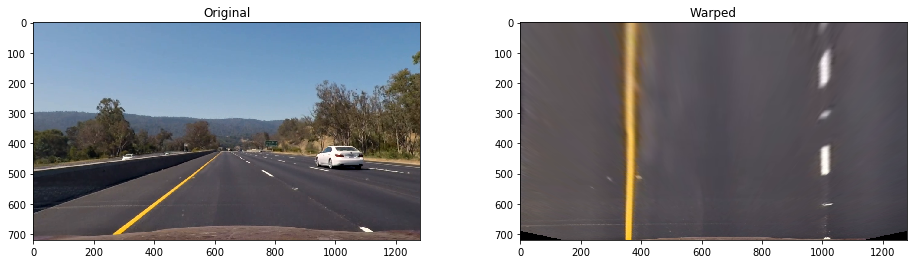

In [26]:
# Move the points in the image
src = np.float32([
    [691, 450],
    [1120, 700],
    [270, 700],
    [595, 450],
])

dst = np.float32([    
    [1010, -100],
    [1010, 720],
    [354, 720],
    [354, -100]
])

plt.figure(figsize=(20,10))
plt.imshow(undistorted)
plt.scatter(src[:,0], src[:,1], c='r', marker='.')
plt.show()

perspective_matrix = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undistorted, perspective_matrix, (1280, 720))
plot2(undistorted, warped, 'Original', 'Warped', 'warped.jpg')

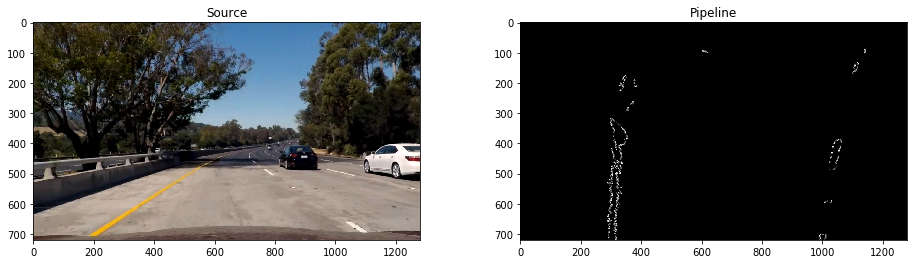

In [154]:
def inRange(min, max):
    def apply(x):
        return cv2.inRange(x, min, max)
    return apply

YELLOW = (np.uint8([20,40,80]), np.uint8([255,255, 255]))
WHITE = (np.uint8([0,200,0]), np.uint8([255,255,255]))

frame = video.get_frame(41)
undistorted = undistort(objpoints, imgpoints, shape=frame.shape[:-1])(frame)

pipeline = compose(
    convert_color(cv2.COLOR_RGB2HLS),
    
    lambda x: cv2.warpPerspective(x, perspective_matrix, (1280, 720), flags=cv2.INTER_LINEAR),
    
    lambda x: np.maximum(inRange(*YELLOW)(x), inRange(*WHITE)(x)),
    sobel(1, 0, ksize=5),
    scale(255),

    
#     fork(
#         compose(
#             lambda x: x[..., 1], # Channel L  
#             sobel(1, 0, ksize=5),
#             scale(1.),
#             threshold(0.1, 1., value=.8)
#         ),
#         compose(
#             lambda x: x[..., 2], # Channel S  
#             threshold(100, 255, value=1.),
#         )
#     ),
    
#     threshold(0.1, , 255),
#     lambda x: x.astype(np.uint8),

    convert_color(cv2.COLOR_GRAY2RGB),
)

transformed = pipeline(undistorted)
plot2(undistorted, transformed, 'Source', 'Pipeline', 'pipeline.jpg')

In [32]:
def find_histogram_peaks(img, y=400, plot_histogram=False):
    hist = np.sum(img[y:, :] > 0, axis=0)
    middle = hist.shape[0]//2
    left = np.argmax(hist[:middle])
    right = np.argmax(hist[middle:]) + middle
    if plot_histogram:
        plt.figure()
        plt.title('Histogram')
        plt.plot(hist, '0.8') 
        plt.plot(left, hist[left], 'r<', label='Left peak')
        plt.plot(right, hist[right], 'r>', label='Right peak')
        plt.legend()
    return left, right

In [33]:
# Ignore this. Scale lines without moving the center.
print(640 - 370*366//472, 640 + 370)

354 1010


Peaks: (293, 1031)
Width: 738 pixels
Center: 640 pixels
Offsets: 347 / 391 pixels
Offset to center: 22.0 pixels


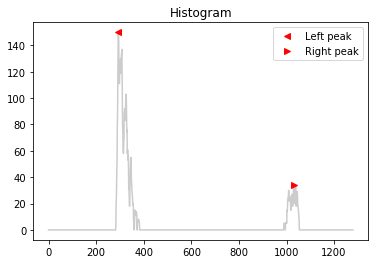

In [34]:
peaks = find_histogram_peaks(transformed[..., 0], plot_histogram=True)
print("Peaks: {}".format(peaks))
print("Width: {} pixels".format(peaks[1] - peaks[0]))
center = frame.shape[1]//2
print("Center: {} pixels".format(center))
print("Offsets: {} / {} pixels".format(center - peaks[0], peaks[1] - center))
print("Offset to center: {} pixels".format((peaks[1] + peaks[0])/2 - center ))
plt.savefig('./output_images/histogram.jpg')

In [35]:
def find_points_in_window(img, start, height, margin):
    window = get_window(img, start, height, margin)
    height = window.shape[0]
    margin = window.shape[1] // 2
    nonzero = np.int32(window.nonzero())
    nonzero[0] += start[0] - height 
    nonzero[1] += start[1] - margin
    return nonzero

In [36]:
def get_window(image, start, height, margin):
    return image[start[0]-height:start[0], start[1] - margin:start[1] + margin]

In [37]:
def get_points(img, start,  margin, n_windows=9, use_median=True, min_points = 10):
    h = img.shape[0] // n_windows
    points = find_points_in_window(img, start, h, margin)

    if len(points[0]) < min_points:
        # Keep original starting point if there are not enough points
        return points, None, False
    
    middle = int(np.median(points[1]) if use_median else np.mean(points[1]))
    return points, middle, True

In [38]:
def calculate_curvature(points, y_eval, ym_per_pix = 3/100, xm_per_pix = 3.7/655):
    # Fit new polynomials to x,y in world space
    pts_y = points[0] * ym_per_pix;
    pts_x = points[1] * xm_per_pix;
    
    c2, c1, c0 = np.polyfit(pts_y, pts_x, deg=2)
    radius = ((1 + (2*c2*y_eval*ym_per_pix + c1)**2)**1.5) / np.absolute(2*c2)
    
    return radius

In [39]:
def fit_points(points, height, deg=2):
    coeffs = np.polyfit(points[0], points[1], deg=deg)
    y = np.linspace(0, height, height, endpoint=False)
    x = 0.
    for c in coeffs:
        x = x * y + c
    return y, x

In [40]:
# def plot_window(imgs, pts, start, height, margin, median, points_found, plot_points):
#     if plot_points:
#         plt.scatter(*reversed(pts), marker='.', alpha=0.01)
    
#     marker= 'g-' if points_found else 'r:' 
#     plt.plot(
#         [start[1] + margin, 
#          start[1] - margin, 
#          start[1] - margin, 
#          start[1] + margin, 
#          start[1] + margin], 
        
#         [start[0] - height, 
#          start[0] - height, 
#          start[0], 
#          start[0], 
#          start[0] - height],
#         marker)
#     marker= 'g-' if points_found else 'r:'
#     plt.plot([median, median], [start[0] - height, start[0]], marker, label='Median')

In [41]:
def plot_window(dst, pts, start, height, margin, median, points_found, plot_points):    
    cv2.rectangle(dst, (start[1]-margin, start[0]), (start[1]+margin, start[0] - height), (0,255,0), 2, cv2.LINE_AA)
    cv2.line(dst, (median, start[0]), (median, start[0] - height), (0,255,0), 2, cv2.LINE_AA)

    return dst
    

In [42]:
# def plot_road_lane(dst, x, y, margin):
#     plt.plot(x, y, 'r')
#     plt.plot(
#         np.append(x - margin, x[::-1] + margin), 
#         np.append(y, y[::-1]), 
#         'r--', alpha=0.4
#     )

In [43]:
def plot_road_lane(dst, x, y, margin):
    pts = np.array([x, y], dtype=np.int32).T
    cv2.polylines(dst, np.int32([pts]), False, (255, 0,0), 10, cv2.LINE_AA)

In [44]:
def update_windows(img, peak, prev_medians=None, n_windows=12, margin=90, max_dx=10, plot_points=False):
    dst = np.zeros_like(img) 
    h = img.shape[0] // n_windows
    points = []
    new_medians = []
    median = peak
    for i in range(n_windows):
        if prev_medians is None or prev_medians[i] is None:
            start_x = median            
        else:
            start_x = prev_medians[i]
            
        start = (img.shape[0] - i*h, np.clip(start_x, margin, img.shape[1] - margin))
        pts, median, found = get_points(img, start, margin, n_windows=n_windows)
        
        if found:
            points.append(pts)
            dx = median - start_x
            median = start_x + np.clip(dx, -max_dx, +max_dx)
            new_medians.append(median)
            plot_window(dst, pts, start, h, margin, median, found, plot_points)              
        else:
            median = start_x
            new_medians.append(None)
            
    if len(points) > 0:
        points = np.hstack(points)
        y, x = fit_points(points, img.shape[0], deg=2)
        curv = calculate_curvature(points, img.shape[0])
        plot_road_lane(dst, x, y, margin)
    else:
        y, x = None, None
        curv = 0
        
    return new_medians, curv, dst, (y, x)

Curvature L: 377.7m
Curvature R: 482.5m
Offset R: 0.1m


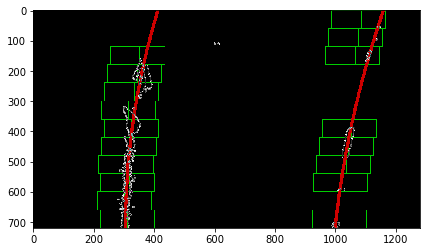

In [130]:
undistorted = undistort(objpoints, imgpoints)(frame)
transformed = pipeline(undistorted)

plt.figure(figsize=(20,10))

peaks = find_histogram_peaks(transformed[..., 0])

# Left
med, _, _, _ = update_windows(transformed[...], peaks[0])
med, curv, dst_1, (y1,x1) = update_windows(transformed[...], peaks[0], prev_medians=med, plot_points=True)

print("Curvature L: {:.1f}m".format(curv))

# Right
med, _, _, _ = update_windows(transformed[...], peaks[1])
med, curv, dst_2, (y2,x2) = update_windows(transformed[...], peaks[1], prev_medians=med, plot_points=True)

print("Curvature R: {:.1f}m".format(curv))
print("Offset R: {:.1f}m".format(((x1[-1] + x2[-1])/2 - center) * 3.7/655))

dst = cv2.addWeighted(dst_1, 1, dst_2, 1, 0)
dst = cv2.addWeighted(transformed, .3, dst, 0.7, 0)

plot1(dst, filename="windows.jpg")

In [127]:
def process_lines(img_smooth=0.8, curv_smooth=0.9):
    smoothed = None # For smoothing
    peaks = None
    medians_left = None
    medians_right = None
    curvature_left = 0.
    curvature_right = 0.
    
    undist = undistort(objpoints, imgpoints)
    
    def apply(frame):
        nonlocal medians_left, medians_right, peaks, curvature_left, curvature_right, smoothed
            
        frame = undist(frame)
        img = pipeline(frame).astype(np.uint8)

        if smoothed is None:
            smoothed = np.copy(img)
        else:
            smoothed = (img_smooth * smoothed  + (1. - img_smooth) * img).astype(np.uint8)
        
        if peaks is None:
            peaks = find_histogram_peaks(smoothed[..., 0])        
            
        # Left
        med_left, curv_left, dst_left, (y1, x1) = update_windows(smoothed, peaks[0], prev_medians=medians_left)

        # Right
        med_right, curv_right, dst_right, (y2, x2) = update_windows(smoothed, peaks[1], prev_medians=medians_right)

        if x1 is not None and x2 is not None:
            x = np.hstack([x1, np.flipud(x2)])
            y = np.hstack([y1, np.flipud(y2)])
            pts = np.array([x, y]).T
            lane = cv2.fillPoly(np.zeros_like(img), np.int32([pts]), (255, 0,0), cv2.LINE_AA)                
            img = cv2.addWeighted(img, 1, lane, 1, 0)                
        
        lines = cv2.addWeighted(dst_left, 1, dst_right, 1, 0)
        img = cv2.addWeighted(img, .5, lines, .5, 0)
        
        img = cv2.warpPerspective(img, perspective_matrix, (1280, 720), flags=cv2.WARP_INVERSE_MAP)
        img = cv2.addWeighted(frame, .6, img, .4, 0)
        
        curvature_left = curv_smooth * curvature_left + (1 - curv_smooth) * curv_left
        curvature_right = curv_smooth * curvature_right + (1 - curv_smooth) * curv_right
        
        curv_text = "Curvature (left / right): {:.1f}m / {:.1f}m".format(curvature_left, curvature_right)
        
        offset = ((x2[-1] + x1[-1]) / 2 - center) * 3.7/655
        offset_text = "Offset: {:.2f}m {} from the center".format(offset, 'left' if offset > 0 else 'right')
        
        img = cv2.putText(img, curv_text, (10,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 1, cv2.LINE_AA)
        img = cv2.putText(img, offset_text, (10,80), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 1, cv2.LINE_AA)
                
        medians_left = med_left    
        medians_right = med_right
        return img
    return apply


video = VideoFileClip("./project_video.mp4")
result = video.fl_image(process_lines())
# result = video.subclip(35,45).fl_image(process_lines())
_ = result.write_videofile("./project-video-result.mp4", audio=False)

[MoviePy] >>>> Building video ./project-video-result.mp4
[MoviePy] Writing video ./project-video-result.mp4


100%|█████████▉| 1260/1261 [02:52<00:00,  7.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project-video-result.mp4 



In [128]:
display_video("./project-video-result.mp4")

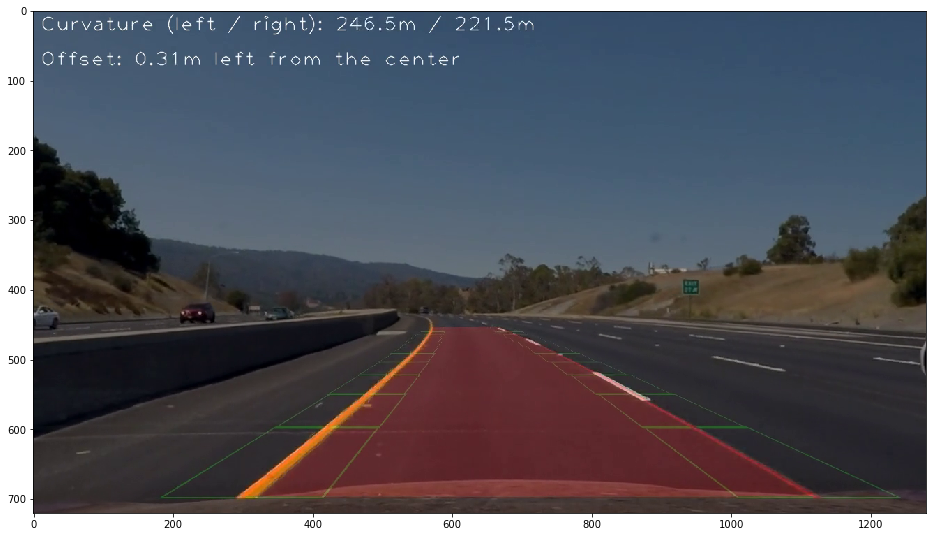

In [129]:
plot1(VideoFileClip("./project-video-result.mp4").get_frame(5), filename='frame.jpg', figsize=(16,10))